In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
import pingouin as pg
from scipy.signal import find_peaks 

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

# load the metabolism object from the repo
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
seed_set = pd.read_csv('../assets/seed_set.csv')['ID'].tolist()

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])

There were 70 compounds in this seed set...
There were 4315 compounds produced in this expansion!


In [2]:
#complexity = pd.read_csv('../assets/kegg_cpds.iterationComplexity.csv',index_col=0)
complexity_metrics = "../assets/kegg_compound_complexity_metrics.csv"
complexity = pd.read_csv(complexity_metrics,index_col=0).set_index("cid")
feature_type = "bertz"
#complexity = complexity[[feature_type]].join(pd.DataFrame(pd.Series(ne_cpds),columns=['iteration']))
complexity = complexity[feature_type].dropna()

In [14]:
scope = [x for x in list(ne_cpds) if x not in seed_set]
complexity = complexity[complexity.index.isin(scope)]

In [17]:
# run all expansions using single compoudn addition:
seed_sets = [seed_set + [x] for x in complexity.index.tolist()]

In [22]:
ne_cpds_list, ne_rxns_list = metabolism.run_expansions_parallel(seed_sets,algorithm="trace")

In [34]:
peak_sizes = []
for c in ne_cpds_list:
    abun = pd.DataFrame(pd.Series(c),columns=['iter']).reset_index().groupby('iter').count()
    x = abun["index"].values
    z = find_peaks(x, height=0,  distance=5,  prominence=30)
    peaks = len(z[0])
    peak_sizes.append(peaks)

In [36]:
complexity = pd.DataFrame(complexity)

In [38]:
complexity["peak_sizes"] = peak_sizes

<Figure size 216x216 with 0 Axes>

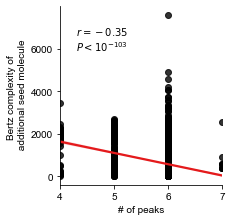

In [84]:
skws={"color": "black"}
cmap = sns.color_palette("Set1")
lkws={'color': cmap[0]}

plt.figure(figsize=(3,3))
g = sns.lmplot(x="peak_sizes",y="bertz",data=complexity,height=3,line_kws=lkws,scatter_kws=skws)

# Rasterize the points
for ax in g.axes.flatten():
    for c in ax.collections:  # the points are stored as collections
        c.set_rasterized(True)
        
        
plt.ylabel("Bertz complexity of \n additional seed molecule")
plt.xlabel("# of peaks")

r,pval = pearsonr(complexity['peak_sizes'].values,complexity[feature_type].values)
d = int(np.ceil(np.log10(pval)))
label = '$r={R}$ \n'.format(R=round(r,2)) + '$P<10^{' + str(d) + '}$'
plt.annotate(label, xy=(0.1, 0.75), xycoords='axes fraction')
plt.savefig("figs/FigSX_lmPlotSingleMoleculeAdditionComplexity.svg")

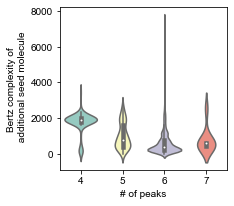

In [82]:
plt.figure(figsize=(3,3))
sns.violinplot(x="peak_sizes",y="bertz",data=complexity,height=3,palette="Set3")
plt.ylabel("Bertz complexity of \n additional seed molecule")
plt.xlabel("# of peaks")
plt.savefig("figs/FigSX_violinPlot.SingleMoleculeAdditionComplexity.svg")

In [47]:
pearsonr(complexity["peak_sizes"].values,complexity[feature_type].values)

(-0.351561689970934, 1.3616568472495272e-104)